In [1]:
import sys
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from preprocessing.config import (
    Config, DatasetConfig, PreprocessingConfig,
    AugmentationConfig, DataLoaderConfig, TransformConfig
)
from preprocessing.dataloader.pipeline import TimeSeriesPipeline
from preprocessing.downloader.huggingface import HuggingFaceDownloader

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [2]:
# Download and prepare the Air Passengers dataset
config = Config(
    dataset=DatasetConfig(
        name="air-passengers",
        repo_id="duol/airpassengers",
        files=["AP.csv"]  # Pass as a list to avoid string splitting
    ),
    preprocessing = PreprocessingConfig(
    transforms=[
        TransformConfig(
            name="MeanScaler",
            params={
                "center": True 
            }
        )
    ]
    ),
    augmentation = AugmentationConfig(
        enabled=False
    ),
    dataloader = DataLoaderConfig(
        batch_size=3,  # Small batch size for visualization
        shuffle=False  # Keep order for visualization
    )
)

# Download the dataset
downloader = HuggingFaceDownloader(config.dataset)
data_path = downloader.download()["AP.csv"]  # Get the path from the returned dict

# Read and prepare the CSV data
import pandas as pd
df = pd.read_csv(data_path)
data = df['#Passengers'].values  # Get passenger counts
data = torch.FloatTensor(data).reshape(12, 12, 1)  # (years, months, features)

print("Data shape:", data.shape, "- (years, months, features)")

# Create dataset with just the input data (no targets needed)
dataset = TensorDataset(data)

Data shape: torch.Size([12, 12, 1]) - (years, months, features)


In [3]:

# Create pipeline and dataloader
pipeline = TimeSeriesPipeline(config)
dataloader = pipeline.create_dataloader(dataset)


In [ ]:
# Get a batch and its transform parameters
batch_and_params = next(iter(dataloader))
print("Batch and params type:", type(batch_and_params))
print("Batch and params content:", batch_and_params)

# Properly unpack based on the structure
if isinstance(batch_and_params, tuple) and len(batch_and_params) == 2:
    batch_tuple, transform_params = batch_and_params
    batch = batch_tuple[0] if isinstance(batch_tuple, tuple) else batch_tuple
else:
    raise ValueError(f"Unexpected dataloader output structure: {batch_and_params}")

print("\nTransform parameters:", transform_params)
print("Transformed batch shape:", batch.shape)

AttributeError: 'list' object has no attribute 'dtype'

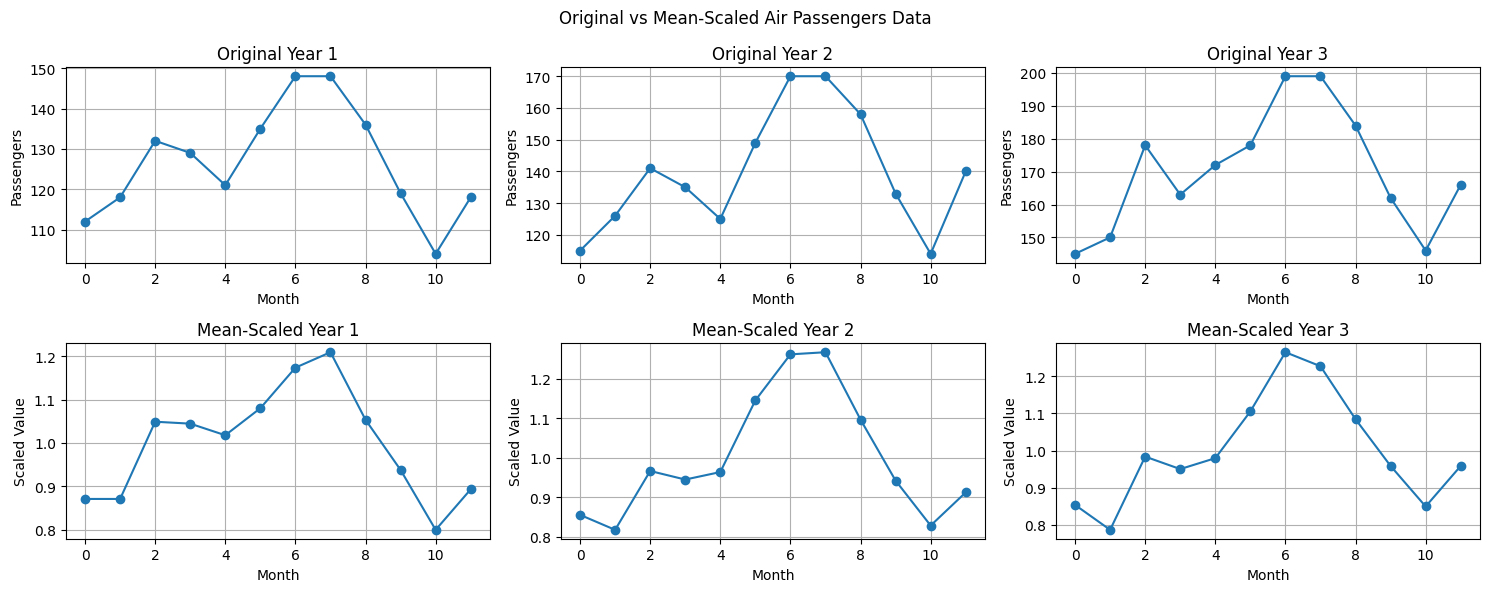

In [5]:
# Visualize original, transformed, and inverse-transformed data
def plot_samples(original, transformed, inverse_transformed, num_samples=3):
    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))
    fig.suptitle('Air Passengers Data Processing Pipeline')
    
    for i in range(num_samples):
        # Plot original
        axes[0, i].plot(original[i, :, 0].numpy(), marker='o')
        axes[0, i].set_title(f'Original Year {i+1}')
        axes[0, i].set_xlabel('Month')
        axes[0, i].set_ylabel('Passengers')
        axes[0, i].grid(True)
        
        # Plot transformed
        axes[1, i].plot(transformed[i, :, 0].numpy(), marker='o')
        axes[1, i].set_title(f'Mean-Scaled Year {i+1}')
        axes[1, i].set_xlabel('Month')
        axes[1, i].set_ylabel('Scaled Value')
        axes[1, i].grid(True)
        
        # Plot inverse transformed
        axes[2, i].plot(inverse_transformed[i, :, 0].numpy(), marker='o')
        axes[2, i].set_title(f'Inverse Transformed Year {i+1}')
        axes[2, i].set_xlabel('Month')
        axes[2, i].set_ylabel('Passengers')
        axes[2, i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Get original data
original_batch = next(iter(DataLoader(dataset, batch_size=3, shuffle=False)))[0]

# Get transformed data and parameters
batch_and_params = next(iter(dataloader))
transformed_tuple, transform_params = batch_and_params
transformed_batch = transformed_tuple[0] if isinstance(transformed_tuple, tuple) else transformed_tuple

# Apply inverse transform
inverse_transformed_batch = pipeline.inverse_transforms(transformed_batch, transform_params)

# Plot all three versions
plot_samples(original_batch, transformed_batch, inverse_transformed_batch)


In [ ]:
# Verify numerical accuracy of inverse transform
reconstruction_error = torch.abs(original_batch - inverse_transformed_batch).mean()
print(f"Mean absolute reconstruction error: {reconstruction_error:.8f}")

# Should be very close to zero (only floating point errors)
